In [2]:
!pip install scikit-multilearn

import re
import os
import tqdm
import nltk
import pickle
import sqlite3
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from nltk.corpus import words
from datetime import datetime
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from itertools import combinations
from keras.models import load_model
from keras.models import Sequential
from tensorflow.keras import layers
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize
from keras.preprocessing import sequence
from scipy.sparse import coo_matrix, hstack
from tensorflow.keras.utils import plot_model
from keras.layers.embeddings import Embedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, LSTM, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization

%matplotlib inline
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings("ignore")
stemmer = SnowballStemmer('english')

%autosave 120

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sAm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sAm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Autosaving every 120 seconds


In [3]:
data = pd.read_csv("data_with_all_tags.csv")
data.head(2)

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count,synopsis_sent_count,CleanedSynopsis,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648,26,set hamburg west germani sever crimin take adv...,...,0,0,0,0,0,0,0,0,0,0
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353,14,grader name griffin bing decid gather entir gr...,...,0,0,0,0,0,0,0,0,0,0


In [4]:
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer = lambda x: str(x).split(", ") )
tag_vect = vectorizer.fit_transform(data["tags"])

In [5]:
tags = vectorizer.get_feature_names()
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('absurd', 259), ('action', 605), ('adult comedy', 124), ('allegory', 123), ('alternate history', 98), ('alternate reality', 198), ('anti war', 108), ('atmospheric', 385), ('autobiographical', 43), ('avant garde', 213), ('blaxploitation', 73), ('bleak', 210), ('boring', 519), ('brainwashing', 103), ('christian film', 39), ('claustrophobic', 80), ('clever', 86), ('comedy', 1795), ('comic', 110), ('cruelty', 422), ('cult', 2531), ('cute', 190), ('dark', 387), ('depressing', 196), ('dramatic', 402), ('entertaining', 726), ('fantasy', 492), ('feel-good', 74), ('flashback', 2801), ('good versus evil', 793), ('gothic', 400), ('grindhouse film', 61), ('haunting', 132), ('historical', 266), ('historical fiction', 118), ('home movie', 148), ('horror', 455), ('humor', 803), ('insanity', 585), ('inspiring', 116), ('intrigue', 154), ('magical realism', 51), ('melodrama', 423), ('murder', 5375), ('mystery', 500), ('neo noir', 700), ('non fiction', 32), ('paranormal', 501), ('philosophical', 222), 

In [6]:
tag_counts = pd.DataFrame(result,columns=['tag','tag_counts'])
tag_counts.head()

,tag,tag_counts
0,absurd,259
1,action,605
2,adult comedy,124
3,allegory,123
4,alternate history,98


In [7]:
tag_counts_sorted = tag_counts.sort_values(['tag_counts'], ascending=False)

In [8]:
tag_counts = tag_counts_sorted['tag'][:30]
tag_counts

43              murder
68            violence
28           flashback
57            romantic
20                cult
56             revenge
52         psychedelic
17              comedy
65         suspenseful
37               humor
29    good versus evil
59              satire
25        entertaining
45            neo noir
58              sadist
1               action
38            insanity
67             tragedy
12              boring
47          paranormal
44             mystery
26             fantasy
36              horror
42           melodrama
19             cruelty
24            dramatic
30              gothic
22                dark
7          atmospheric
62        storytelling
Name: tag, dtype: object

In [9]:
tags_30 = list(tag_counts)

In [10]:
data['tags']

0                                                   murder
1                                                flashback
2                  suspenseful, neo noir, murder, violence
3                                           cult, violence
4        murder, anti war, violence, flashback, tragedy...
                               ...                        
13752                                   paranormal, murder
13753                                             romantic
13754                                     autobiographical
13755    cruelty, murder, cult, violence, flashback, ps...
13756                                               murder
Name: tags, Length: 13757, dtype: object

In [11]:
#Deleting Every Tags other than TOP 30 Tags

for le in tqdm(range(data.shape[0])):
    a = []
    b = data['tags'][le].split(",")
    c = ''
    
    for i in range(len(b)):        
        for j in tags_30:
            temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
            
            if temp == j:        #Comparing with the TOP 30 tags
                a.append(j)
        
    if a:
        data['tags'][le] = ", ".join(a)
    else:
         data['tags'][le] = np.nan        

100%|██████████████████████████████████████████████████████████████████████████| 13757/13757 [00:02<00:00, 5383.21it/s]


In [12]:
#Deleting the rows that have NaN Values
data = data.dropna() 

In [13]:
data['tags']

0                                                   murder
1                                                flashback
2                  suspenseful, neo noir, murder, violence
3                                           cult, violence
4                     murder, violence, flashback, tragedy
                               ...                        
13751                            comedy, sadist, flashback
13752                                   paranormal, murder
13753                                             romantic
13755    cruelty, murder, cult, violence, flashback, ps...
13756                                               murder
Name: tags, Length: 13010, dtype: object

In [14]:
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer = lambda x: str(x).split(", "))
tag_vect = vectorizer.fit_transform(data["tags"])

In [15]:
tags = vectorizer.get_feature_names()
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('action', 605), ('atmospheric', 385), ('boring', 519), ('comedy', 1795), ('cruelty', 422), ('cult', 2531), ('dark', 387), ('dramatic', 402), ('entertaining', 726), ('fantasy', 492), ('flashback', 2801), ('good versus evil', 793), ('gothic', 400), ('horror', 455), ('humor', 803), ('insanity', 585), ('melodrama', 423), ('murder', 5375), ('mystery', 500), ('neo noir', 700), ('paranormal', 501), ('psychedelic', 1800), ('revenge', 2313), ('romantic', 2729), ('sadist', 618), ('satire', 780), ('storytelling', 346), ('suspenseful', 1026), ('tragedy', 536), ('violence', 4138)]


In [16]:
len(result)

30

In [17]:
conn = sqlite3.connect('data30.db')
data.to_sql('data30', conn, if_exists='replace', index=False)
train = pd.read_sql("Select * From data30 where split = 'train' OR split='val'",conn)
test =  pd.read_sql("Select * From data30 where split = 'test'",conn)
conn.close()

In [18]:
X_train = train["CleanedSynopsis"]
y_train= train["tags"]

X_test = test["CleanedSynopsis"]
y_test= test["tags"]

In [19]:
cnt_vectorizer = CountVectorizer(binary='true', max_features = 30).fit(y_train)
y_train_multilabel = cnt_vectorizer.transform(y_train)
y_test_multilabel = cnt_vectorizer.transform(y_test)

In [20]:
print("Dimensions of data Y_train_multilabel:",y_train_multilabel.shape,"Y_test_multilabel:",y_test_multilabel.shape)

Dimensions of data Y_train_multilabel: (10375, 30) Y_test_multilabel: (2635, 30)


# Word2Vec

In [21]:
X_train_new = []

for i in tqdm(range(len(list(X_train)))):
    X_train_new.append(X_train[i].split(" "))

100%|█████████████████████████████████████████████████████████████████████████| 10375/10375 [00:00<00:00, 14590.92it/s]


In [22]:
with open('glove.6B.300d.pkl', 'rb') as f:
    new_model = pickle.load(f)
    words =  set(new_model.keys())

In [23]:
X_train_multilabel = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train.values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in words:
            vector += new_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_multilabel.append(vector)

100%|███████████████████████████████████████████████████████████████████████████| 10375/10375 [00:10<00:00, 999.51it/s]


In [24]:
X_test_multilabel = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test.values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in words:
            vector += new_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_multilabel.append(vector)

100%|████████████████████████████████████████████████████████████████████████████| 2635/2635 [00:02<00:00, 1006.30it/s]


<h1>OneVsRestClassifier + SGDClassifier with LOG Loss :</h1>

In [25]:
sgl = SGDClassifier(loss='log', class_weight='balanced')

clf = OneVsRestClassifier(sgl)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [26]:
prediction1 = clf.predict(X_test_multilabel)

precision1 = precision_score(y_test_multilabel, prediction1, average='micro')

recall1 = recall_score(y_test_multilabel, prediction1, average='micro')

f1_score1 = 2*((precision1 * recall1)/(precision1 + recall1))

print("precision1: {:.4f}, recall1: {:.4f}, F1-measure: {:.4f}".format(precision1, recall1, f1_score1))

precision1: 0.1893, recall1: 0.6597, F1-measure: 0.2942


In [27]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction1[k])[0],"\n")

Movie:  Kaakha..Kaakha: The Police
Actual genre:  murder, violence, flashback, good versus evil, romantic, revenge
Predicted tag:  ['cruelty' 'murder' 'neo' 'noir' 'revenge' 'sadist' 'tragedy' 'violence'] 

Movie:  Wedding Belles
Actual genre:  dark, entertaining
Predicted tag:  ['gothic' 'insanity' 'murder' 'romantic'] 

Movie:  Zeus and Roxanne
Actual genre:  romantic
Predicted tag:  ['evil' 'fantasy' 'gothic' 'romantic' 'versus'] 

Movie:  White Cargo
Actual genre:  romantic, flashback
Predicted tag:  ['boring' 'gothic' 'humor' 'insanity' 'revenge'] 

Movie:  Yôjinbô
Actual genre:  comedy, dark, murder, cult, violence, atmospheric, good versus evil, suspenseful
Predicted tag:  ['action' 'boring' 'comedy' 'cult' 'evil' 'flashback' 'good' 'gothic'
 'horror' 'humor' 'murder' 'neo' 'noir' 'psychedelic' 'revenge' 'sadist'
 'suspenseful' 'tragedy' 'versus' 'violence'] 



<h2> OneVsRestClassifier + SGDClassifier with HINGE Loss : </h2>

In [28]:
sgh = SGDClassifier(loss='hinge', class_weight='balanced')

clf = OneVsRestClassifier(sgh)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [29]:
prediction2 = clf.predict(X_test_multilabel)

precision2 = precision_score(y_test_multilabel, prediction2, average='micro')

recall2 = recall_score(y_test_multilabel, prediction2, average='micro')

f1_score2 = 2*((precision2 * recall2)/(precision2 + recall2))

print("precision2: {:.4f}, recall2: {:.4f}, F1-measure: {:.4f}".format(precision2, recall2, f1_score2))

precision2: 0.1921, recall2: 0.6314, F1-measure: 0.2946


In [30]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction2[k])[0],"\n")

Movie:  F.I.S.T
Actual genre:  revenge, murder, violence
Predicted tag:  ['action' 'comedy' 'dramatic' 'entertaining' 'flashback' 'melodrama'
 'murder' 'sadist' 'satire' 'violence'] 

Movie:  The Crow: City of Angels
Actual genre:  comedy, gothic, murder, neo noir, paranormal, cult, violence, flashback, good versus evil, insanity, romantic, revenge, sadist
Predicted tag:  ['evil' 'flashback' 'good' 'gothic' 'horror' 'insanity' 'murder'
 'paranormal' 'revenge' 'sadist' 'satire' 'versus' 'violence'] 

Movie:  Duo shuai
Actual genre:  violence, sadist
Predicted tag:  ['cruelty' 'cult' 'flashback' 'insanity' 'murder' 'neo' 'noir' 'revenge'
 'sadist' 'tragedy' 'violence'] 

Movie:  Safe in Hell
Actual genre:  murder
Predicted tag:  ['comedy' 'insanity' 'melodrama' 'murder'] 

Movie:  The Fury
Actual genre:  paranormal, insanity, cult, gothic, flashback
Predicted tag:  ['action' 'boring' 'flashback' 'insanity' 'murder' 'paranormal' 'versus'] 



<h2> OneVsRestClassifier + LogisticRegression:</h2>

In [31]:
lr = LogisticRegression(class_weight='balanced')

clf = OneVsRestClassifier(lr)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [32]:
prediction3 = clf.predict(X_test_multilabel)

precision3 = precision_score(y_test_multilabel, prediction3, average='micro')

recall3 = recall_score(y_test_multilabel, prediction3, average='micro')

f1_score3 = 2*((precision3 * recall3)/(precision3 + recall3))

print("precision3: {:.4f}, recall3: {:.4f}, F1-measure: {:.4f}".format(precision3, recall3, f1_score3))

precision3: 0.2117, recall3: 0.6573, F1-measure: 0.3203


In [33]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction3[k])[0],"\n")

Movie:  Le goût des autres
Actual genre:  violence, entertaining, storytelling, romantic
Predicted tag:  ['boring' 'comedy' 'dramatic' 'entertaining' 'melodrama' 'romantic'
 'satire' 'tragedy'] 

Movie:  Tekkon kinkurîto
Actual genre:  psychedelic, atmospheric, violence
Predicted tag:  ['cruelty' 'cult' 'evil' 'flashback' 'good' 'insanity' 'murder'
 'psychedelic' 'revenge' 'sadist' 'tragedy' 'versus' 'violence'] 

Movie:  Bitten
Actual genre:  comedy
Predicted tag:  ['boring' 'comedy' 'cult' 'entertaining' 'fantasy' 'flashback' 'gothic'
 'humor' 'insanity' 'murder' 'neo' 'noir' 'revenge' 'suspenseful'
 'violence'] 

Movie:  Kuch Kuch Hota Hai
Actual genre:  flashback
Predicted tag:  ['flashback' 'melodrama' 'paranormal' 'romantic' 'tragedy'] 

Movie:  Julien Donkey-Boy
Actual genre:  cruelty, murder, mystery, psychedelic, romantic, sadist
Predicted tag:  ['cruelty' 'flashback' 'horror' 'psychedelic' 'romantic' 'sadist'
 'tragedy' 'violence'] 



<h1>Conclusion</h1>

In [34]:
from prettytable import PrettyTable

tabel = PrettyTable()

tabel.field_names=['Model', 'Vectorizer', 'Precision','recall','f1_score']


tabel.add_row(['SGDClassifier(log)', 'AVG W2V',  round(precision1, 3), round(recall1, 3), round(f1_score1, 3)])

tabel.add_row(['SGDClassifier(hinge)','AVG W2V', round(precision2, 3),  round(recall2, 3), round(f1_score2, 3)])

tabel.add_row(['LogisticRegression','AVG W2V', round(precision3, 3), round(recall3, 3), round(f1_score3, 3)])


print(tabel)

+----------------------+------------+-----------+--------+----------+
|        Model         | Vectorizer | Precision | recall | f1_score |
+----------------------+------------+-----------+--------+----------+
|  SGDClassifier(log)  |  AVG W2V   |   0.189   |  0.66  |  0.294   |
| SGDClassifier(hinge) |  AVG W2V   |   0.192   | 0.631  |  0.295   |
|  LogisticRegression  |  AVG W2V   |   0.212   | 0.657  |   0.32   |
+----------------------+------------+-----------+--------+----------+


<h1>LSTM-CNN Model</h1>

In [35]:
max_review_length = 400
X_train = sequence.pad_sequences(X_train_multilabel, maxlen=max_review_length, padding='post')
X_test = sequence.pad_sequences(X_test_multilabel, maxlen=max_review_length, padding='post')

In [35]:
inputt = 8252
batch_size = 60
epochs = 10

In [36]:
model = Sequential()

model.add(Embedding(inputt, 50, input_length=max_review_length))

model.add(LSTM(100, return_sequences=True))

model.add(Dropout(0.2))

model.add(BatchNormalization())

model.add(LSTM(100, return_sequences=True))

model.add(Dropout(0.2))

model.add(BatchNormalization())

model.add(LSTM(100, return_sequences=True))

model.add(Dropout(0.2))

model.add(Activation('relu'))

model.add(BatchNormalization())

model.add(GlobalMaxPooling1D())

model.add(Dense(30, activation='relu'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           412600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 100)          60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 100)          400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 400, 100)          80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 400, 100)         

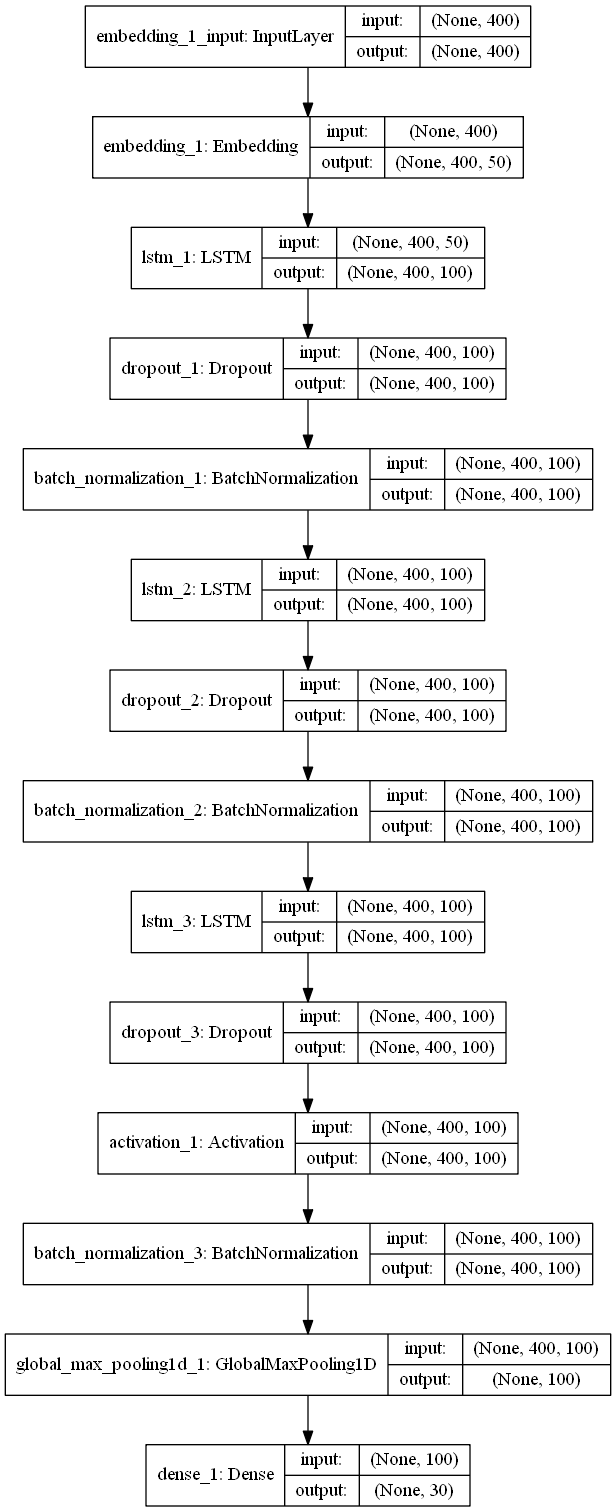

In [37]:
plot_model(model, 'model.png', show_shapes=True)

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train_multilabel, 
          batch_size = batch_size,
          validation_data=(X_test, y_test_multilabel),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10375 samples, validate on 2635 samples
Epoch 1/10
10375/10375 [==============================] - 384s 37ms/step - loss: 26.2867 - accuracy: 0.1641 - val_loss: 27.4611 - val_accuracy: 0.1214
Epoch 2/10
10375/10375 [==============================] - 388s 37ms/step - loss: 26.2083 - accuracy: 0.1680 - val_loss: 24.8945 - val_accuracy: 0.0433
Epoch 3/10
10375/10375 [==============================] - 397s 38ms/step - loss: 26.1948 - accuracy: 0.1680 - val_loss: 24.0487 - val_accuracy: 0.0433
Epoch 4/10
10375/10375 [==============================] - 388s 37ms/step - loss: 26.1924 - accuracy: 0.1680 - val_loss: 23.0400 - val_accuracy: 0.0433
Epoch 5/10
10375/10375 [==============================] - 390s 38ms/step - loss: 26.1927 - accuracy: 0.1680 - val_loss: 23.8933 - val_accuracy: 0.0433
Epoch 6/10
10375/10375 [==============================] - 396s 38ms/step - loss: 26.1906 - accuracy: 

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test_multilabel, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.0432637557387352


In [41]:
model.save('lstm_model.h5') #Saving the Model for Future Use

In [36]:
model = load_model('lstm_model.h5') #Loading the Model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [38]:
model_prediction = model.predict(X_test, verbose=0)

In [39]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ", y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(model_prediction[k])[0],"\n")

Movie:  Beautiful Creatures
Actual genre:  comedy, paranormal, flashback, good versus evil, psychedelic, romantic, melodrama, suspenseful
Predicted tag:  ['action' 'entertaining' 'flashback' 'good' 'gothic' 'insanity' 'murder'
 'neo' 'psychedelic' 'romantic' 'suspenseful' 'versus' 'violence'] 

Movie:  Mach 2
Actual genre:  violence
Predicted tag:  ['action' 'entertaining' 'flashback' 'good' 'gothic' 'insanity' 'murder'
 'neo' 'psychedelic' 'romantic' 'suspenseful' 'versus' 'violence'] 

Movie:  Fluke
Actual genre:  cruelty, flashback
Predicted tag:  ['action' 'entertaining' 'flashback' 'good' 'gothic' 'insanity' 'murder'
 'neo' 'psychedelic' 'romantic' 'suspenseful' 'versus' 'violence'] 

Movie:  Mississippi Burning
Actual genre:  dramatic, cult, suspenseful, murder
Predicted tag:  ['action' 'entertaining' 'flashback' 'good' 'gothic' 'insanity' 'murder'
 'neo' 'psychedelic' 'romantic' 'suspenseful' 'versus' 'violence'] 

Movie:  Batman Returns
Actual genre:  dark, fantasy, gothic, mys